# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 28 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 28 ноября, -4 балла после 06:00 5 декабря, -6 баллов после 06:00 12 декабря, -8 баллов после 19 декабря

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from timeit import default_timer

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# %load_ext pycodestyle_magic

In [39]:
# %%pycodestyle


class MyKmeans: 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, 
                 random_state=None, init='random', epsilon=0.001):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        :init - медод инициализации начальных центроид
        """
        
        self.k = k
        self.epsilon = epsilon
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        
        if metric == 'euclidean':
            self.dist_function = self.distance_euclidean
        else:
            raise RuntimeError(metric)
        
        if init == 'random':
            self.init_centroids_function = self.init_centroids_random
        elif init == 'k-means++':
            self.init_centroids_function = self.init_centroids_kmeans_pp
        else:
            raise RuntimeError(init)
    
    def init_centroids_random(self):
        return np.random.randn(self.k, self.X.shape[1])
    
    def init_centroids_kmeans_pp(self):
        centr = np.empty((self.k, self.X.shape[1]))
        centr[0] = self.X[np.random.choice(self.X.shape[0])]
        for i in range(1, self.k):
            tmp_distances = self.dist_function(self.X, centr[:i, :]).min(axis=0)
            centr[i] = self.X[np.random.choice(self.X.shape[0], 
                                               p=tmp_distances/tmp_distances.sum())]
        return centr
    
    def distance_euclidean(self, X, cent):
        X1 = np.sum(X ** 2, axis=1).reshape(-1, 1)
        X2 = np.sum(cent ** 2, axis=1).reshape(1, -1)
        return np.sqrt(X1 - 2 * np.dot(X, cent.T) + X2).T
    
    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        self.centroids_new = np.empty((self.k, X.shape[1]))
        
        ## Your Code Here
        # ...
        
        self.X = np.array(X)
        self.y = np.array(X)
        self.centroids = self.init_centroids_function()
        
        for _ in range(self.max_iter):
            self.labels = self.dist_function(self.X, self.centroids).argmin(axis=0)
            for i in range(self.k):
                if np.any(self.labels == i):
                    self.centroids_new[i] = np.mean(self.X[self.labels == i], axis=0)
                else:
                    self.centroids_new[i] = self.X[np.random.choice(X.shape[1])]

            if np.sum(abs(self.centroids - self.centroids_new)) < self.epsilon:
                self.centroids = np.copy(self.centroids_new)
                break
                
            self.centroids = np.copy(self.centroids_new)
            
        self.labels = self.dist_function(self.X, self.centroids).argmin(axis=0)
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        X = np.array(X)
        return self.dist_function(X, self.centroids).argmin(axis=0)

In [40]:
class MiniBatchKMeans(MyKmeans):
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, 
                 random_state=None, init='random', epsilon=0.001,
                 batch_size=1):
            
        super(MiniBatchKMeans, self).__init__(k=k, metric=metric, max_iter=max_iter, 
                                              random_state=random_state, init=init, 
                                              epsilon=epsilon)
        self.batch_size = batch_size
    
    def gen_batch(self, X):
        indexes = np.random.permutation(X.shape[0])
        return X[indexes]
    
    def fit(self, X, y=None):
        np.random.seed(self.random_state)
        
        self.labels = np.empty(X.shape[0])
        
        self.centroids = np.empty((self.k, X.shape[1]))
        self.centroids_new = np.empty((self.k, X.shape[1]))
        
        self.X = np.array(X)
        self.y = np.array(X)
        self.centroids = self.init_centroids_function()
        
        for _ in range(self.max_iter):
            self.labels = self.dist_function(self.X, self.centroids).argmin(axis=0)
            for i in range(self.k):
                if np.any(self.labels == i):
                    batch = self.gen_batch(self.X[self.labels == i])
                    self.centroids_new[i] = np.mean(batch, axis=0)
                else:
                    self.centroids_new[i] = self.X[np.random.choice(X.shape[1])]

            if np.sum(abs(self.centroids - self.centroids_new)) < self.epsilon:
                self.centroids = np.copy(self.centroids_new)
                break
                
            self.centroids = np.copy(self.centroids_new)
            
        self.labels = self.dist_function(self.X, self.centroids).argmin(axis=0)
        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [41]:
from sklearn.datasets import make_blobs

In [42]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

In [43]:
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

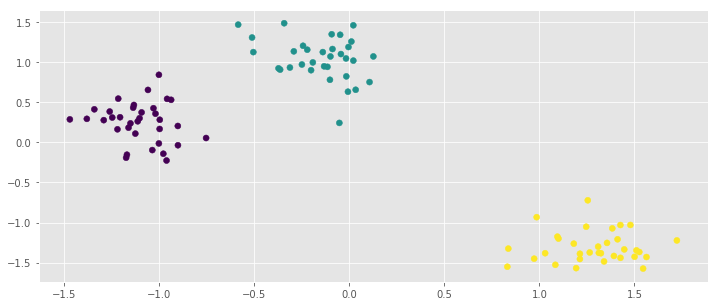

In [44]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [45]:
## Работоспособность MyKmeans

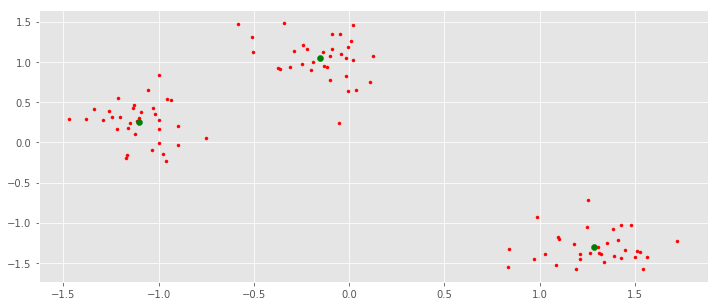

In [46]:
clf = MyKmeans(k=3, metric='euclidean' , init='random')
clf.fit(X, y)
plt.scatter(X[:,0], X[:, 1], marker='.', c='r')
plt.scatter(clf.centroids[:,0], clf.centroids[:, 1], marker='o', c='g')

In [47]:
print(clf.predict(X))

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [48]:
## Работоспособность MyKmeans++

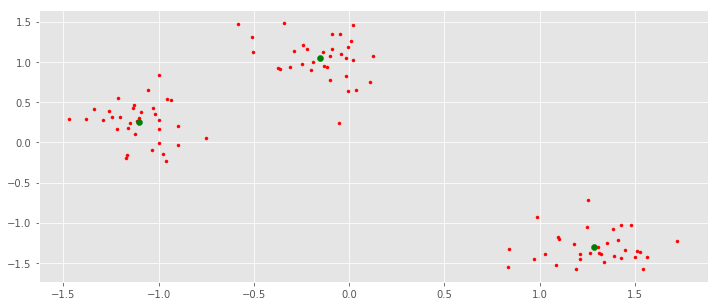

In [49]:
clf_kpp = MyKmeans(k=3, metric='euclidean' , init='k-means++')
clf_kpp.fit(X, y)
plt.scatter(X[:,0], X[:, 1], marker='.', c='r')
plt.scatter(clf_kpp.centroids[:,0], clf_kpp.centroids[:, 1], marker='o', c='g')

In [50]:
print(clf_kpp.predict(X))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [51]:
## Работоспособность MyKmeans с MiniBatchMyKmeans

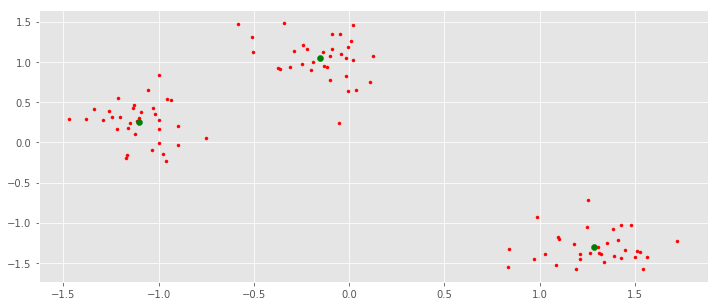

In [52]:
clf_mb = MiniBatchKMeans(k=3, batch_size=16)
clf_mb.fit(X, y)
plt.scatter(X[:,0], X[:, 1], marker='.', c='r')
plt.scatter(clf_mb.centroids[:,0], clf_mb.centroids[:, 1], marker='o', c='g')

In [53]:
print(clf_mb.predict(X))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [54]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans

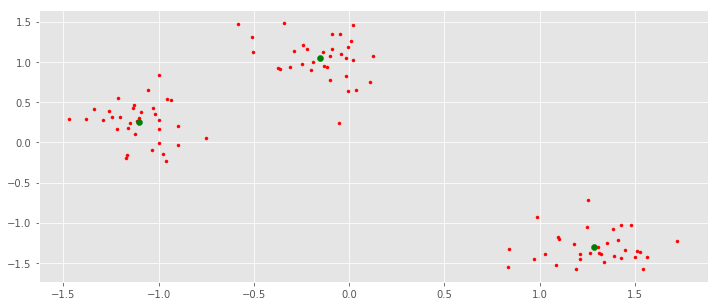

In [55]:
clf_kpp_mb = MiniBatchKMeans(k=3, init='k-means++' , batch_size=16)
clf_kpp_mb.fit(X, y)
plt.scatter(X[:,0], X[:, 1], marker='.', c='r')
plt.scatter(clf_kpp_mb.centroids[:,0], clf_kpp_mb.centroids[:, 1], marker='o', c='g')

In [56]:
print(clf_kpp_mb.predict(X))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [57]:
%%time
## Время выполнения алгоритма MyKmeans
clf = KMeans(n_clusters=3, max_iter=1000, init='random')
clf.fit(X, y)

CPU times: user 11.4 ms, sys: 1.91 ms, total: 13.3 ms
Wall time: 11.5 ms


In [58]:
%%time
## Время выполнения алгоритма MyKmeans
my_clf = MyKmeans(k=3, max_iter=1000)
my_clf.fit(X, y)

CPU times: user 2.41 ms, sys: 2.45 ms, total: 4.86 ms
Wall time: 3.78 ms


In [59]:
%%time
## Время выполнения алгоритма MyKmeans++
my_clf_kpp = MyKmeans(k=3, init='k-means++', max_iter=1000)
my_clf_kpp.fit(X, y)

CPU times: user 3 ms, sys: 3.29 ms, total: 6.29 ms
Wall time: 4.48 ms


In [60]:
%%time
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
my_clf_kpp_mb = MiniBatchKMeans(k=3, batch_size=16, max_iter=1000)
my_clf_kpp_mb.fit(X, y)

CPU times: user 3.14 ms, sys: 3.11 ms, total: 6.25 ms
Wall time: 4.91 ms


In [61]:
%%time
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
my_clf_kpp_mb = MiniBatchKMeans(k=3, init='k-means++', batch_size=16, max_iter=1000)
my_clf_kpp_mb.fit(X, y)

CPU times: user 2.67 ms, sys: 2.87 ms, total: 5.54 ms
Wall time: 4.22 ms


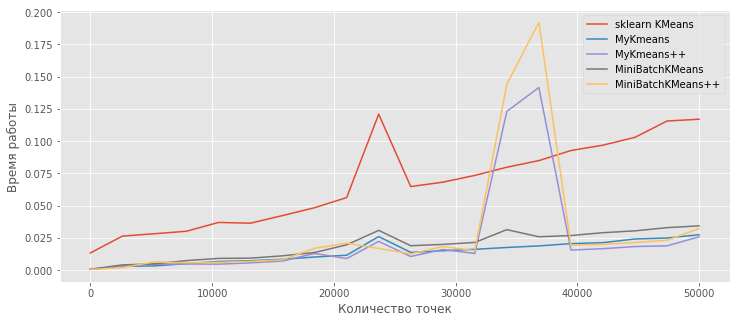

In [62]:
# Проверка времени работы
sizes = np.linspace(3, 50000, 20, dtype=int)
methods = [(KMeans(n_clusters=3, max_iter=100), 'sklearn KMeans'),
          (MyKmeans(k=3, max_iter=100, random_state=42), 'MyKmeans'),
          (MyKmeans(k=3, max_iter=100, random_state=42, init='k-means++'), 'MyKmeans++'),
          (MiniBatchKMeans(k=3, max_iter=100, random_state=42, batch_size=10), 'MiniBatchKMeans'),
          (MiniBatchKMeans(k=3, max_iter=100, random_state=42, 
                           init='k-means++', batch_size=10), 'MiniBatchKMeans++')]

time = np.empty((len(methods), sizes.shape[0]))
for a, k in enumerate(sizes):
    X, y = make_blobs(n_samples=k, n_features=2, centers=3,
                      cluster_std=1, shuffle=True, random_state=42)

    for b, method in enumerate(methods):
        time0 = default_timer()
        method[0].fit(X)
        time[b][a] = default_timer() - time0

for i, method in enumerate(methods):
    plt.plot(sizes, time[i], label=method[1])

plt.xlabel('Количество точек')
plt.ylabel('Время работы')
plt.legend()
plt.show()

In [63]:
# Вопрос на засыпку, откуда эти пики в sklearn и в k-means++
# Ответа на этот вопрос я не знаю :с

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [64]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [65]:
# Предобработка
df_sns = df_sns.iloc[:, 4:]

In [66]:
df_sns.head()
df_sns = (df_sns - df_sns.mean(axis=0)) / df_sns.std(axis=0)

In [67]:
N = 9 # Кластеров

In [68]:
def info_features(clf, X, fnum=7, N=9):
    for i in range(N):
        X_tmp = clf.predict(X)
        X_cur = X[clf.labels == i]
        print(f'Class {i}: ' + str(X_cur.shape[0]) + ' оbjects')
        print(X.columns[X[clf.labels == i].sum(axis=0).argsort()[::-1][:fnum]].values)
        print(50 * '-')

In [69]:
## MyKMeans
my_clf = MyKmeans(k=N)
my_clf.fit(df_sns)

In [70]:
info_features(my_clf, df_sns)

Class 0: 758 оbjects
['marching' 'band' 'music' 'rock' 'god' 'football' 'swimming']
--------------------------------------------------
Class 1: 991 оbjects
['softball' 'volleyball' 'basketball' 'sports' 'football' 'shopping'
 'church']
--------------------------------------------------
Class 2: 834 оbjects
['hollister' 'abercrombie' 'shopping' 'mall' 'clothes' 'hair'
 'cheerleading']
--------------------------------------------------
Class 3: 19763 оbjects
['blonde' 'tennis' 'jesus' 'death' 'soccer' 'drunk' 'sports']
--------------------------------------------------
Class 4: 900 оbjects
['kissed' 'drugs' 'hair' 'sex' 'drunk' 'die' 'clothes']
--------------------------------------------------
Class 5: 521 оbjects
['bible' 'jesus' 'god' 'church' 'death' 'die' 'music']
--------------------------------------------------
Class 6: 4533 оbjects
['shopping' 'mall' 'cute' 'dance' 'dress' 'clothes' 'swimming']
--------------------------------------------------
Class 7: 1162 оbjects
['hot' 'sexy

In [71]:
## MyKMeans++
my_clf_kpp = MyKmeans(k=N, init='k-means++')
my_clf_kpp.fit(df_sns)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in less


In [72]:
info_features(my_clf_kpp, df_sns)

Class 0: 919 оbjects
['hot' 'sexy' 'cute' 'mall' 'dance' 'hair' 'clothes']
--------------------------------------------------
Class 1: 2329 оbjects
['basketball' 'football' 'baseball' 'softball' 'sports' 'volleyball'
 'soccer']
--------------------------------------------------
Class 2: 826 оbjects
['hollister' 'abercrombie' 'shopping' 'mall' 'clothes' 'hair'
 'cheerleading']
--------------------------------------------------
Class 3: 369 оbjects
['drunk' 'sex' 'blonde' 'hair' 'death' 'sexy' 'dance']
--------------------------------------------------
Class 4: 3770 оbjects
['shopping' 'dress' 'dance' 'cute' 'mall' 'band' 'marching']
--------------------------------------------------
Class 5: 1873 оbjects
['death' 'die' 'god' 'music' 'rock' 'jesus' 'tennis']
--------------------------------------------------
Class 6: 372 оbjects
['bible' 'jesus' 'god' 'church' 'music' 'death' 'die']
--------------------------------------------------
Class 7: 18743 оbjects
['blonde' 'tennis' 'soccer' 'jes

In [73]:
## MyKMeans с MiniBatchMyKMeans
my_clf_mb = MiniBatchKMeans(k=N, batch_size='32')
my_clf_mb.fit(df_sns)

In [74]:
info_features(my_clf_mb, df_sns)

Class 0: 2605 оbjects
['football' 'basketball' 'soccer' 'sports' 'softball' 'tennis' 'church']
--------------------------------------------------
Class 1: 715 оbjects
['volleyball' 'softball' 'basketball' 'shopping' 'sports' 'football'
 'swimming']
--------------------------------------------------
Class 2: 508 оbjects
['baseball' 'football' 'basketball' 'rock' 'sports' 'cheerleading'
 'soccer']
--------------------------------------------------
Class 3: 469 оbjects
['bible' 'jesus' 'god' 'church' 'death' 'die' 'music']
--------------------------------------------------
Class 4: 19020 оbjects
['blonde' 'jesus' 'death' 'bible' 'tennis' 'drunk' 'die']
--------------------------------------------------
Class 5: 754 оbjects
['marching' 'band' 'music' 'rock' 'swimming' 'football' 'god']
--------------------------------------------------
Class 6: 846 оbjects
['hollister' 'abercrombie' 'shopping' 'mall' 'clothes' 'hair'
 'cheerleading']
--------------------------------------------------
Class

In [75]:
## MyKMeans++ с MiniBatchMyKMeans
my_clf__kpp_mb = MiniBatchKMeans(k=N, batch_size='32',  init='k-means++')
my_clf__kpp_mb.fit(df_sns)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in less


In [76]:
info_features(my_clf__kpp_mb, df_sns)

Class 0: 421 оbjects
['bible' 'jesus' 'god' 'church' 'death' 'music' 'die']
--------------------------------------------------
Class 1: 898 оbjects
['softball' 'volleyball' 'basketball' 'sports' 'shopping' 'football'
 'church']
--------------------------------------------------
Class 2: 4555 оbjects
['shopping' 'cute' 'dance' 'mall' 'clothes' 'hot' 'band']
--------------------------------------------------
Class 3: 889 оbjects
['kissed' 'drugs' 'hair' 'sex' 'die' 'drunk' 'rock']
--------------------------------------------------
Class 4: 19091 оbjects
['blonde' 'jesus' 'bible' 'death' 'drunk' 'marching' 'sex']
--------------------------------------------------
Class 5: 2273 оbjects
['soccer' 'football' 'basketball' 'sports' 'tennis' 'swimming' 'church']
--------------------------------------------------
Class 6: 500 оbjects
['baseball' 'football' 'basketball' 'rock' 'sports' 'cheerleading'
 'soccer']
--------------------------------------------------
Class 7: 542 оbjects
['dress' 'shop

In [77]:
## Вывод
"""
1. Самый большой кластер содержит около 19 - 20 тыс объектов:
    Главные признаки 'blonde', 'tennis' 'jesus'
    Вывод: Сложно интерпретировать
    
2. Второй по величине содержит около 4 тыс объектов:
    Главные признаки 'shopping', 'mall', 'cute', 'dance', etc
    Вывод: Легко видна взаимосвязь: видимо к кластеру относятся
           Люди (девушки, но не точно), Который следят за своим стилем, 
           Любят ходить по магазинам и ставаются выглядеть привлекательно
    
3. Третий по величине содержит около 2 тыс объектов:
    Главные признаки 'football', 'baseball', 'soccer', 'basketball', etc
    Вывод: Опять же достаточно очевидно: спортсмены и увлекающиеся спортом
    
-- Дальше не по величине, в остальных по разному от 500 до 1000 объектов -- 

4. Четвертый* кластер  (*Рандомная нумерация):
    Главные признаки 'marching', 'band', 'music', 'rock', etc
    Вывод: Вероятно музыканты, участники местных рок-групп и их компании
    
5. Пятый кластер:
    Главные признаки 'kissed', 'sex', 'drugs', 'hair', etc
    Вывод: Тот самый, самый интересный класс общества, с которыми никогда не
        бывает скучно. Любители литературы и искусства и философии.
        Необычные, умные и прилежные ученики
        
6. Шестой кластер:
    Главные признаки 'bible', 'jesus', 'god', 'church', etc
    Вывод: Верующие дети из каких-нибудь воскреных школ или верующих семей
        В России не встречал, но в Штатах, как показывают в фильмах, собираются
        в компании и пропогандируют правильное поведение и любовь в ближним
        
7. Седьмой кластер:
    Главные признаки 'hollister', 'abercrombie', 'mall', 'shopping', etc
    Вывод: Что-то очень похожее на второй класс

8 & 9. Оставшиеся два кластера сложно харатеризовать, потому что они каждый раз разные
    Часто еще выделяются классы спорсменов по типу второго и
    Что-то типа ['hot' 'sexy' 'cute'], тоже часто появляется
------------------------------------------------------------------------------------

Особо заметной разницы между обычным k-means и k-means++ я не увидел, 
разве что второй чуть стабилнее не застревает в стациоарных точках
отличных от минимума, но это заметно только на игрушеных данных,
на настоящих же, я все равно не могу на глаз определить правильно
все склассифицировалось или нет

"""

'Хы'

'Хы'